# Sentinel-5P Level 3 daily composites  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[Sentinel-5P](https://registry.opendata.aws/sentinel5p/)

*This dataset is external to the Digital Earth Africa platform.*

## Background

This data set consists of observations from the Sentinel-5 Precursor (Sentinel-5P) satellite of the European Commission’s Copernicus Earth Observation Programme. Sentinel-5P is a polar orbiting satellite that completes 14 orbits of the Earth a day. It carries the TROPOspheric Monitoring Instrument (TROPOMI) which is a spectrometer that senses ultraviolet (UV), visible (VIS), near (NIR) and short wave infrared (SWIR) to monitor ozone, methane, formaldehyde, aerosol, carbon monoxide, nitrogen dioxide and sulphur dioxide in the atmosphere. The satellite was launched in October 2017 and entered routine operational phase in March 2019. Data is available from July 2018 onwards.


## Description

This notebook demonstrates retrieval of Sentinel-5P level 3 daily composites data from the AWS Public Data program. 

Two streams, NRTI (2-3 days latency) and OFFL (aound 10 days lantency), are available.

Examples covered in this notebook:
1. Query daily NO2 with quality masking

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime

import datacube
from datacube.testutils.io import rio_slurp_xarray,rio_slurp_reproject
from datacube.utils.geometry import GeoBox, box, CRS

import sys
sys.path.append('../Scripts')
from deafrica_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='S5P')

### Analysis parameters

In [95]:
# Define the area of interest
lat = 9.05
lon = 7.45
buffer = 0.5

# Accra, Ghana
lat = 5.6
lon = 0.2
buffer = 0.5

# Lagos, Nigeria
lat = 6.0
lon = 3.4
buffer = 0.5

# Nairobi, Kenya
lat = -1.3
lon =36.8
buffer = 1.0

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer*0.75, lat+buffer*0.75)
lon_range = (lon-buffer, lon+buffer)


## Visualise area with a Landsat image


In [96]:
bands = ["blue", "green", "red"]
ls = dc.load(product = 'ga_ls8c_gm_2_annual', x = lon_range, y = lat_range, time = ('2018-01-01', '2019-01-01'), measurements = bands)

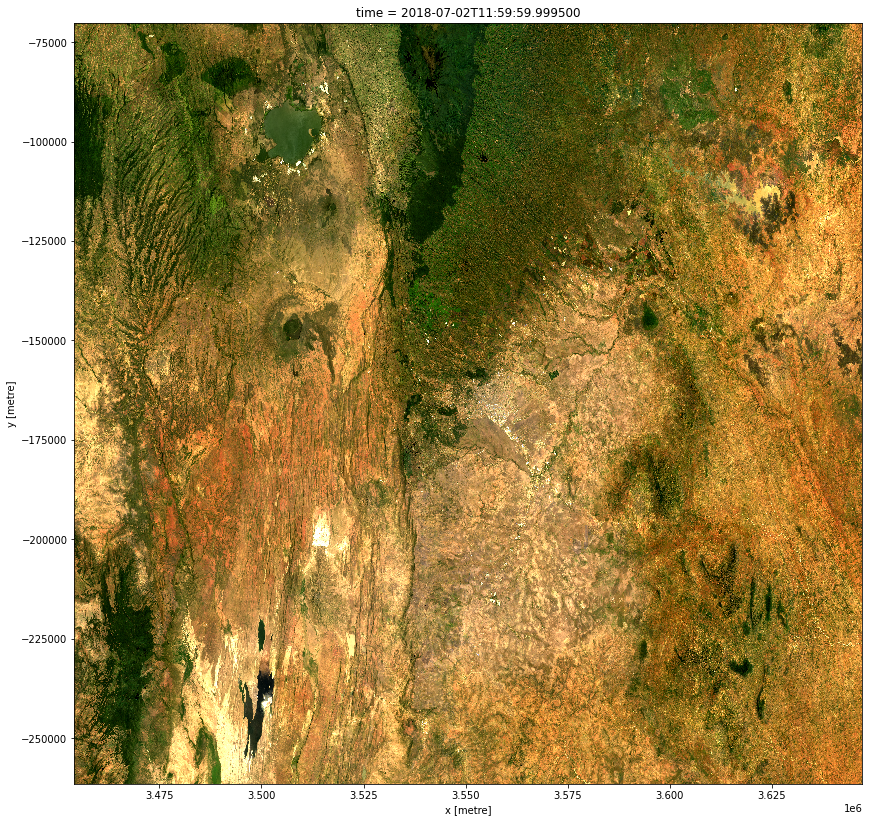

In [97]:
rgb(ls, index=0, size=14)

## NO2



In [86]:
product_names = {'daily_nitrogendioxide_tropospheric_column': 'L3__NO2'.ljust(10,'_'),
                 'daily_methane_mixing_ratio': 'L3__CH4___',
                'daily_sulferdioxide_tropospheric_column': 'L3__SO2'.ljust(10,'_'),}


In [89]:
var = 'daily_nitrogendioxide_tropospheric_column_mask50'
var = 'daily_methane_mixing_ratio_mask50'

stream = 'NRTI'
stream = 'OFFL'

def get_5p_l3_var(var, stream = 'NRTI', x = None, y = None, time = None, resolution = None, output_crs = None, **kwargs):
    """
    """
    # find product name based on var
    if 'mask' in var:
        product =product_names[var.split('_mask')[0]]
    else: product = product_names[var]
    # convert time to array of dates
    dates = np.arange(np.datetime64(time[0], dtype='M8[D]'), np.datetime64(time[1], dtype='M8[D]')+1)
    # define query bounding box
    if 'crs' is kwargs: input_crs = CRS(crs)
    else: input_crs = CRS('EPSG:4326')
    gbox = box(x[0], y[0], x[1], y[1], crs = input_crs)
    # define output bounding box
    output_gbox = gbox.to_crs(crs=CRS(output_crs))
    # define output grid
    output_grid = GeoBox.from_geopolygon(output_gbox, resolution = resolution)
    # go through dates to retrieve data
    datasets = []
    for date64 in dates:
        date = date64.astype(datetime)
        fname = 'https://meeo-s5p.s3.amazonaws.com/COGT/{0}/{1}/{2:04d}/{3:02d}/S5P_{0}_{1}_{2:04d}{3:02d}{4:02d}_PRODUCT_{5}_4326.tif'.format(stream, product, date.year, date.month, date.day, var)
        #print(fname)
        # reproject
        print(date)
        da = rio_slurp_xarray(fname, gbox = output_grid)
        ds = da.expand_dims({'time':[date64]}).to_dataset(name = var)
        datasets.append(ds)
    # merge the datasets into one
    output_ds = xr.concat(datasets, dim='time')
    return output_ds

#ds = get_5p_l3_var(var, stream, output_crs=ls.attrs['crs'], **query)

lat_range = (-40, 40)
lon_range = (-20, 60)

ds_2019 = get_5p_l3_var(var, stream, output_crs='EPSG:4326', resolution=(0.05, 0.05), x=lon_range, y=lat_range,
                       time=("2019-03-20", "2019-04-05"))

ds_2020 = get_5p_l3_var(var, stream, output_crs='EPSG:4326', resolution=(0.05, 0.05), x=lon_range, y=lat_range,
                       time=("2020-03-20", "2020-04-05"))

2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2020-03-20
2020-03-21
2020-03-22
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-28
2020-03-29
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-04
2020-04-05


In [90]:
ds1 = ds_2019[var].where(ds_2019[var]!=ds_2019[var].attrs['nodata']).mean(dim='time')
ds2 = ds_2020[var].where(ds_2020[var]!=ds_2020[var].attrs['nodata']).mean(dim='time')

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [91]:
ds1 = ds1.expand_dims({'time':['2019-04-01']})
ds2 = ds2.expand_dims({'time':['2020-04-01']})

In [92]:
ds = xr.merge([ds1, ds2])

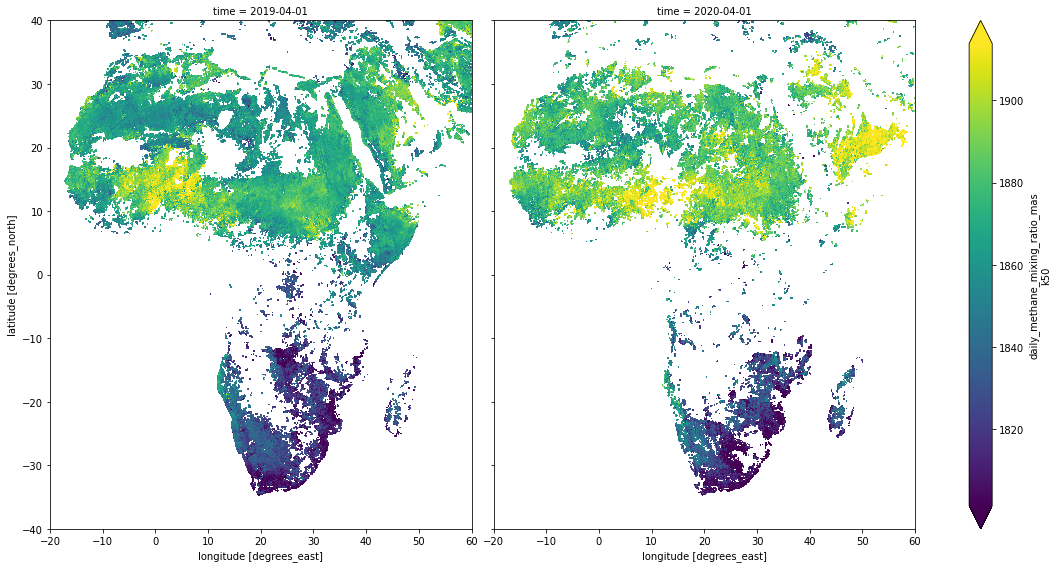

In [93]:
ds[var].plot(col='time', robust=True, figsize=(16,8));

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


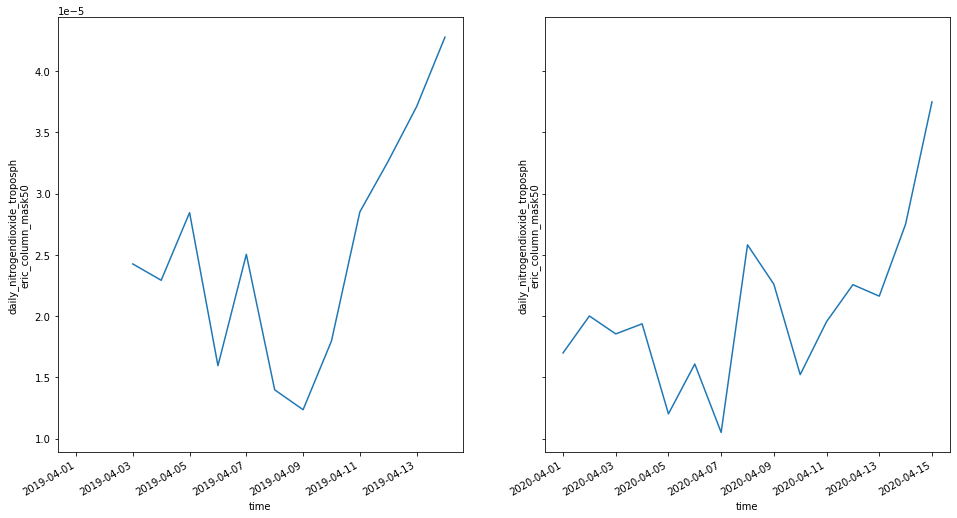

In [104]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(16,8))
ds_2019[var].where(ds_2019[var]!=ds_2019[var].attrs['nodata']).mean(['latitude','longitude']).plot(ax=ax[0]);
ds_2020[var].where(ds_2020[var]!=ds_2020[var].attrs['nodata']).mean(['latitude','longitude']).plot(ax=ax[1]);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)